In [1]:
!pip install sentence-transformers faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.0 MB/s 
     |████████████████████████████████| 85.5 MB 1.2 MB/s 
     |████████████████████████████████| 5.5 MB 86.6 MB/s 
     |████████████████████████████████| 1.3 MB 73.9 MB/s 
     |████████████████████████████████| 182 kB 90.5 MB/s 
     |████████████████████████████████| 7.6 MB 69.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=57f259105c2ce374ed0c9293263d71614568f9e9cc77e62f1fcb13f06be639e8
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [2]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import faiss

from textblob import TextBlob
from pprint import pprint
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

In [3]:
model_bert = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# data = pd.read_csv('./data/wiki_movie_plots_deduped.csv')

# Comment the following lines for local execution
from google.colab import drive
drive.mount('/content/gdrive')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Mounted at /content/gdrive


In [8]:
# Comment this block for local execution
data = pd.read_csv('/content/gdrive/My Drive/NLP_Dataset/Summary_SummarizedSubtitle_30_100_Final.csv')
# data = pd.read_csv('/content/gdrive/My Drive/Projects/NLP Project/wiki_movie_plots_deduped.csv')
# data = data.iloc[:5000]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               79 non-null     int64  
 1   Release Year             79 non-null     int64  
 2   Title                    79 non-null     object 
 3   Origin/Ethnicity         79 non-null     object 
 4   Plot                     79 non-null     object 
 5   imdbRating               79 non-null     float64
 6   imdbID                   79 non-null     object 
 7   Subtitles                79 non-null     object 
 8   Summary_Subtitle_30_100  79 non-null     object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.7+ KB


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

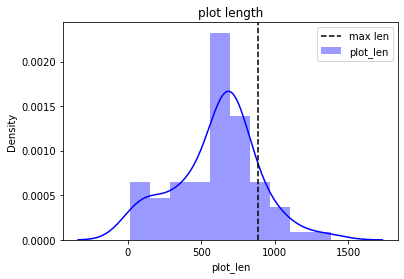

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


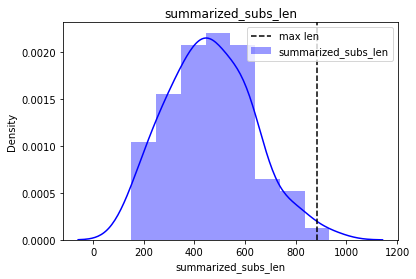

In [9]:
plot_column_name = "Plot"
plot_summarized_column_name = "Summary_Subtitle_30_100"

data = data[['Title', plot_column_name, 'imdbRating', plot_summarized_column_name]]
data.dropna(inplace=True)
data.drop_duplicates(subset=[plot_column_name, plot_summarized_column_name], inplace=True)

data['plot_len'] = data[plot_column_name].apply(lambda words: len(words.split()))
data['summarized_subs_len'] = data[plot_summarized_column_name].apply(lambda words: len(words.split()))

max_seq_len = np.round(data['plot_len'].mean() + data['plot_len'].std()).astype(int)
sns.distplot(data['plot_len'], hist=True, kde=True, color='b', label='plot_len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

max_seq_len_1 = np.round(data['summarized_subs_len'].mean() + data['summarized_subs_len'].std()).astype(int)
sns.distplot(data['summarized_subs_len'], hist=True, kde=True, color='b', label='summarized_subs_len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('summarized_subs_len'); plt.legend()
plt.show()

In [11]:
def fetch_movie_info(dataframe_idx):
    info = data.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    meta_dict['imdbRating'] = info['imdbRating']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [12]:
encoded_plot_data = model_bert.encode(data.Plot.tolist())
encoded_plot_data = np.asarray(encoded_plot_data.astype('float32'))
index_plot = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_plot.add_with_ids(encoded_plot_data, np.array(range(0, len(data))))
faiss.write_index(index_plot, 'movie_plot.index')

In [13]:
encoded_summarized_subs_data = model_bert.encode(data.Summary_Subtitle_30_100.tolist())
encoded_summarized_subs_data = np.asarray(encoded_summarized_subs_data.astype('float32'))
index_subs = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_subs.add_with_ids(encoded_summarized_subs_data, np.array(range(0, len(data))))
faiss.write_index(index_subs, 'movie_summarized_subs.index')

In [14]:
# query="adventure and horror"
# query="movie about space and time"
# query="science fiction with time travel"
# query="magic and fantasy"
# query = "dogs and cats"
# query="scary movie with dolls"
query="europe with rains"

results_plot = search(query, top_k=3, index=index_plot, model=model_bert)

print("\n Plot -- \n")
for result in results_plot:
    print('\t', result)


results_subs = search(query, top_k=3, index=index_subs, model=model_bert)

print("\n Subs -- \n")
for result in results_subs:
    print('\t',result)

>>>> Results in Total Time: 0.0206298828125

 Plot -- 

	 {'Title': "Charlie's Angels: Full Throttle", 'imdbRating': 4.9}
	 {'Title': 'The Way', 'imdbRating': 7.3}
	 {'Title': "The Slammin' Salmon", 'imdbRating': 6.4}
>>>> Results in Total Time: 0.008705377578735352

 Subs -- 

	 {'Title': "We'll Never Have Paris", 'imdbRating': 4.6}
	 {'Title': 'Inglourious Basterds', 'imdbRating': 8.3}
	 {'Title': "The Slammin' Salmon", 'imdbRating': 6.4}


**Fine tuning**

In [15]:
def _removeNonAscii(s): 
  return "".join(i for i in s if ord(i) < 128)

In [16]:
batch_size = 16 #Batch size
num_queries = 5 #Number of queries to generate for every paragraph
max_length_paragraph = 512 #Max length for paragraph
max_length_query = 64   #Max length for output query
paragraphs_plot = data.Plot.tolist()
paragraphs_subs = data.Summary_Subtitle_30_100.tolist()

In [17]:
tokenizer = T5Tokenizer.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model_finetuned = T5ForConditionalGeneration.from_pretrained('BeIR/query-gen-msmarco-t5-large-v1')
model_finetuned.eval()

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [18]:
device = 'cuda'
model_finetuned.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [19]:
# run this only once to generate synthetic queries

from tqdm import tqdm

with open('generated_queries_all_plot.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs_plot), batch_size)):
        sub_paragraphs = paragraphs_plot[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model_finetuned.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3672: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 5/5 [00:16<00:00,  3.23s/it]


In [20]:
with open('generated_queries_all_subs.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs_subs), batch_size)):
        sub_paragraphs = paragraphs_subs[start_idx:start_idx+batch_size]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model_finetuned.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


# New section

In [21]:
# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model_subs = SentenceTransformer(modules=[word_emb, pooling])
model_plot = SentenceTransformer(modules=[word_emb, pooling])

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
## PLOT

train_examples_plot = [] 
with open('/content/gdrive/My Drive/NLP_Dataset/generated_queries_all_plot.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples_plot.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader_plot = datasets.NoDuplicatesDataLoader(train_examples_plot, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss_plot = losses.MultipleNegativesRankingLoss(model_plot)

In [23]:
train_examples_subs = [] 
with open('/content/gdrive/My Drive/NLP_Dataset/generated_queries_all_subs.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples_subs.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader_subs = datasets.NoDuplicatesDataLoader(train_examples_subs, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss_subs = losses.MultipleNegativesRankingLoss(model_subs)

In [24]:
## PLOT
# Tune the model
num_epochs = 3
warmup_steps_plot = int(len(train_dataloader_plot) * num_epochs * 0.1)
model_plot.fit(train_objectives=[(train_dataloader_plot, train_loss_plot)], epochs=num_epochs, warmup_steps=warmup_steps_plot, show_progress_bar=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

In [25]:
## SUBS
# Tune the model
num_epochs = 3
warmup_steps_subs = int(len(train_dataloader_subs) * num_epochs * 0.1)
model_subs.fit(train_objectives=[(train_dataloader_subs, train_loss_subs)], epochs=num_epochs, warmup_steps=warmup_steps_subs, show_progress_bar=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

Iteration:   0%|          | 0/49 [00:00<?, ?it/s]

In [26]:
os.makedirs('/content/gdrive/MyDrive/NLP_Dataset/search', exist_ok=True)
model_plot.save('/content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot')
model_subs.save('/content/gdrive/MyDrive/NLP_Dataset/search/search-model-subs')

In [27]:
model_plot = SentenceTransformer('/content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot')
model_subs = SentenceTransformer('/content/gdrive/MyDrive/NLP_Dataset/search/search-model-subs')

In [28]:
!zip -r search_model.zip "/content/gdrive/MyDrive/NLP_Dataset/search"

  adding: content/gdrive/MyDrive/NLP_Dataset/search/ (stored 0%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/ (stored 0%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/config_sentence_transformers.json (deflated 26%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/config.json (deflated 44%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/pytorch_model.bin (deflated 8%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/tokenizer_config.json (deflated 44%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/special_tokens_map.json (deflated 42%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/vocab.txt (deflated 53%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/tokenizer.json (deflated 71%)
  adding: content/gdrive/MyDrive/NLP_Dataset/search/search-model-plot/sentence_bert_config.json (deflated 4%)
  adding: con

In [29]:
## PLOT
encoded_data_finetuned_plot = model_plot.encode(data.Plot.tolist())
encoded_data_finetuned_plot = np.asarray(encoded_data_finetuned_plot.astype('float32'))
index_finetuned_plot = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_finetuned_plot.add_with_ids(encoded_data_finetuned_plot, np.array(range(0, len(data))))
faiss.write_index(index_finetuned_plot, 'movie_finetuned_plot.index')

In [30]:
## SUBS
encoded_data_finetuned_subs = model_subs.encode(data.Summary_Subtitle_30_100.tolist())
encoded_data_finetuned_subs = np.asarray(encoded_data_finetuned_subs.astype('float32'))
index_finetuned_subs = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index_finetuned_subs.add_with_ids(encoded_data_finetuned_subs, np.array(range(0, len(data))))
faiss.write_index(index_finetuned_subs, 'movie_finetuned_subs.index')

In [31]:
# query="adventure and horror"
# query="murder mystery with travel"
# query="science fiction with time travel"
# query="magic and fantasy"
# query = "dogs and cats"
query="europe with rains"

results_finetuned_plot = search(query, top_k=3, index=index_finetuned_plot, model=model_plot)

print("\n")
for result in results_finetuned_plot:
    print('\t', result)

results_finetuned_subs = search(query, top_k=3, index=index_finetuned_subs, model=model_subs)

print("\n")
for result in results_finetuned_subs:
    print('\t', result)

>>>> Results in Total Time: 0.01455235481262207


	 {'Title': "Charlie's Angels: Full Throttle", 'imdbRating': 4.9}
	 {'Title': "We'll Never Have Paris", 'imdbRating': 4.6}
	 {'Title': 'The Way', 'imdbRating': 7.3}
>>>> Results in Total Time: 0.011592388153076172


	 {'Title': "We'll Never Have Paris", 'imdbRating': 4.6}
	 {'Title': 'Inglourious Basterds', 'imdbRating': 8.3}
	 {'Title': "The Slammin' Salmon", 'imdbRating': 6.4}


In [32]:
test_queries = [
    "Query 1",
    "Query 2",
    "Query 3",
    "Query 4",
    "Query 5",
    "Query 6",
    "Query 7",
    "Query 8",
    "Query 9",
    "Query 10"
]

expected_movies = [
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"]
]

actual_movies_from_plot_model = [
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 4", "Title 3"],
    ["Title 1", "Title 5", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 6", "Title 3"],
    ["Title 1", "Title 2", "Title 7"],
    ["Title 1", "Title 2", "Title 8"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"]
]

actual_movies_from_subs_model = [
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 4", "Title 3"],
    ["Title 1", "Title 5", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 2", "Title 3"],
    ["Title 1", "Title 6", "Title 3"],
    ["Title 1", "Title 2", "Title 7"],
    ["Title 1", "Title 2", "Title 8"],
    ["Title 1", "Title 2", "Title 9"],
    ["Title 1", "Title 2", "Title 11"]
]

def model_accuracy(expected_results, actual_results):
    current_score = 0.0
    total_score = 0.0
    for index, _ in enumerate(expected_results):
        current_score += len(set(expected_results[index]) & set(actual_results[index]))
        total_score += len(expected_results[index])
    return current_score/total_score

print(model_accuracy(expected_movies, actual_movies_from_plot_model))
print(model_accuracy(expected_movies, actual_movies_from_subs_model))

0.8333333333333334
0.7666666666666667
